# 패턴인식 설계 과제
# <한국어 문장 긍정,부정문 이진분류>
## 단국대학교 컴퓨터공학과 정민준
jmj284@gmail.com<br> 
010-9391-0801

# <모델 사용 및 테스트 코드>

##<학습 및 테스트 환경> <br>
본 프로그램은 'Google Colab' 환경에서 작성 되었습니다.<br>
플랫폼: 'Goolge Colab'<br> 
GPU: Tesla T4<br> 
GPU API: cuda<br>
<br>사용한 언어 및 라이브러리는 아래와 같습니다.
<br>

## <언어> <br>

###1. python3
Version: 3.7.14 (default, Sep  8 2022, 00:06:44)<br>
GCC 7.5.0<br>

## <라이브러리> <br>

###1. transformers
Version: 4.23.1<br> 
License: Apache<br>

###2. torch
Version: 1.12.1+cu113<br>
License: BSD-3<br>

###3. tensorflow)<br>
Version: 2.9.2<br>
License: Apache 2.0<br>

###4. keras
Version: 2.9.0<br>
License: Apache 2.0<br>

###5. scikit-learn
Version: 1.0.2<br>
License: new BSD<br>

###6. pandas
Version: 1.3.5<br> 
License: BSD-3-Clause<br>

###7. numpy
Version: 1.21.6<br>
License: BSD<br>

###8. matplotlib
Version: 3.2.2<br> 
License: PSF<br>

## <사전학습모델> 
KoBERT-Transfomers<br>
License: Apache 2.0

## <참고자료>

1. https://mccormickml.com/2019/07/22/BERT-fine-tuning/

2. https://github.com/monologg/KoBERT-Transformers/blob/master/kobert_transformers/tokenization_kobert.py

3. https://velog.io/@seolini43/일상연애-주제의-한국어-대화-BERT로-이진-분류-모델-만들기파이썬Colab-코드

# 모델 호출 및 설정

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip3 install kobert-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 2.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 7.9 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595734 sha256=94f1f0cf9b0f9307c5205084bca187974197e451823c921c8d06c9a6c7d8bb2c
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-1q4ikwnf
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-1q4ikwnf
     |████████████████████████████████| 129 kB 7.7 MB/s 
     |████████████████████████████████| 54.7 MB 25 kB/s 
     |████████████████████████████████| 4.5 MB 12.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.6 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:42tcmalloc: large alloc 1147494400 bytes == 0x397fa000 @  0x7f4055268615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 881.9 MB 1

In [3]:
import tensorflow as tf
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pandas as pd
from transformers import BertTokenizer
import csv
import numpy as np
import random
import time
import datetime

In [4]:
# GPU 확인하기
n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


In [ ]:
#코랩 환경에서 gpu 사용가능 여부를 판별 및 device 할당 위해서 사용

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

In [5]:
#코랩 환경에서 구글 드라이브 사용시 마운트 필요, 불필요 혹은 오류 발생시 주석 처리 후 실행
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [6]:
import csv
test = pd.read_csv('/drive/MyDrive/kor_bin_data/test_data.csv',encoding="utf-8")

In [ ]:
from kobert_transformers import get_tokenizer
tokenizer = get_tokenizer()

model = BertForSequenceClassification.from_pretrained('/drive/MyDrive/P_OR_N_MODEL')
model.cuda()

# 모델 사용

In [13]:
#시그모이드
def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


test_ans = [] #모델의 결과 저장
test_prob = [] #가능성 저장

#시작 시간 설정
t0 = time.time()

#테스트셋 데이터 전처리
def convert_input_data(sentences):
    sentences = ["[CLS] " + str(sentences) + " [SEP]"]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 150

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

#모델 사용
def Emotion_Binary_Classification(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    
    #시그모이드 함수, 확률 판단
    pred = sigmoid(logits)
    
    #결과 판단
    result = np.argmax(pred)

    return [result,pred]


In [ ]:
s = input("분류할 문장을 입력하세요: ")
a,p = Emotion_Binary_Classification(s)

if a == 0:
  print('"',s,'"',"는 부정문입니다.")
else:
  print('"',s,'"',"는 긍정문입니다.")  

# 모델 평가

In [ ]:
from kobert_transformers import get_tokenizer
tokenizer = get_tokenizer()

model = BertForSequenceClassification.from_pretrained('/drive/MyDrive/P_OR_N_MODEL')
model.cuda()

In [9]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    
# 시간 표시 함수
def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [10]:
#시그모이드
def sigmoid(x): 
    return 1.0/(1 + np.exp(-x))

def flat_accuracy(preds, labels):
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):

    # 반올림
    elapsed_rounded = int(round((elapsed)))
    
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))


test_ans = [] #모델의 결과 저장
test_prob = [] #가능성 저장

#시작 시간 설정
t0 = time.time()

#테스트셋 데이터 전처리
def convert_input_data(sentences):
    sentences = ["[CLS] " + str(sentences) + " [SEP]"]

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    MAX_LEN = 150

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

#모델 사용
def Determining_Acute_Ischemic_Stroke(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    
    #시그모이드 함수, 확률 판단
    pred = sigmoid(logits)
    
    #결과 판단
    result = np.argmax(pred)

    return [result,pred]

#이진 분류 결과(0 or 1)이 담길 정답 리스트
test_ans = []

#이진 분류 결과의 확률([0~1,0~1])이 담길 정답 리스트
test_prob = []

#입력 데이터
d = test.Sentences
d.reset_index(drop=True, inplace=True)

#실제 정답 
labels = test.Emotions

for i in range(len(d)):
  #함수 호출, 이진분류 결과는 a, 확률은 p
  a,p = Determining_Acute_Ischemic_Stroke(d[i])
  test_ans.append(a) #결과 값은 test_ans에 저장
  test_prob.append(p) #확률 값은 test_prob에 저장

print("분류에 소요된 시간: {:}".format(format_time(time.time() - t0)))

분류에 소요된 시간: 0:02:11


총 테스트 데이터의 수:  9113
Accuracy : 0.898167
AUC Score: 0.955392



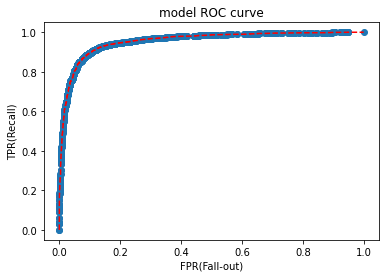

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#probabilty중 정답이 1일 확률이 담길 리스트 
t_prob =[]

print('총 테스트 데이터의 수: ', len(test_prob))

#probabilty중 정답이 1일 확률(model.predict_proba() 와 동일)
for i in test_prob:
  t_prob.append(i[0][1])

cnt = 0
for i in range(len(test_ans)):
  if test_ans[i] == labels[i]:
      cnt += 1

print('Accuracy :',round(cnt/len(test_ans),6))      
# roc_curve 그래프 그리기
fpr, tpr, thresholds = roc_curve(labels, t_prob)

roc = pd.DataFrame({'FPR(Fall-out)': fpr, 'TPRate(Recall)': tpr, 'Threshold': thresholds})

plt.scatter(fpr, tpr)
plt.title('model ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');
plt.plot(fpr, tpr, 'r--')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# 최적의 threshold
#print('idx:',optimal_idx, 'threshold:', optimal_threshold)

# AUC 면적 구하기
auc_score = roc_auc_score(labels, t_prob)
print('AUC Score:',round(auc_score,6))
print()